# Preprocessing danych

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_frame = pd.read_csv('../Data/Raw_data_2023.csv', encoding='unicode_escape', sep=",")
data_frame.dtypes

Month                               object
Day                                  int64
Week day                            object
Hour                                 int64
Dry-Bulb Temp (°C)                 float64
Heating Load (kW)                  float64
Chiller Output (kW)                float64
Chiller Input (kW)                 float64
Total Building Electric [kW]       float64
Precool Coil Load (kW)             float64
Preheat Coil Load (kW)             float64
Terminal Cooling Coil Load (kW)    float64
Terminal Heating Coil Load (kW)    float64
Ventilation Fan (kW)               float64
Exhaust Fan (kW)                   float64
Terminal Fan (kW)                  float64
Vent. Reclaim Device (kW)          float64
Lighting (kW)                      float64
Electric Equipment (kW)            float64
dtype: object

In [3]:
base_df = data_frame[['Hour','Dry-Bulb Temp (°C)']]
base_df

,Hour,Dry-Bulb Temp (°C)
0,0,-4.3
1,1,-4.1
2,2,-4.0
3,3,-3.8
4,4,-3.5
...,...,...
8755,19,0.2
8756,20,0.3
8757,21,0.3
8758,22,0.3


In [4]:
month_df= data_frame['Month'].values
month_df

array(['Jan', 'Jan', 'Jan', ..., 'Dec', 'Dec', 'Dec'], dtype=object)

In [5]:
month_encoded = pd.get_dummies(month_df, columns = ['Month'])
month_encoded

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,False,False,True,False,False,False,False,False,False,False,False,False
8756,False,False,True,False,False,False,False,False,False,False,False,False
8757,False,False,True,False,False,False,False,False,False,False,False,False
8758,False,False,True,False,False,False,False,False,False,False,False,False


In [6]:
weekday_df = data_frame['Week day'].values
weekday_df

array(['Sunday', 'Sunday', 'Sunday', ..., 'Sunday', 'Sunday', 'Sunday'],
      dtype=object)

In [7]:
weekday_encoded = pd.get_dummies(weekday_df, columns = ['Week day'])
weekday_encoded

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,False,False,False,True,False,False,False
1,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False
3,False,False,False,True,False,False,False
4,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...
8755,False,False,False,True,False,False,False
8756,False,False,False,True,False,False,False
8757,False,False,False,True,False,False,False
8758,False,False,False,True,False,False,False


In [8]:
X_train = np.concatenate((base_df, month_encoded, weekday_encoded), axis=1)
print(X_train.shape)

(8760, 21)


In [9]:
y_train= data_frame['Chiller Output (kW)'].values
y_train

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
data_frame_2024 = pd.read_csv('../Data/Raw_data_2024.csv', encoding='unicode_escape', sep=",")
data_frame_2024.dtypes
base_2024_df = data_frame_2024[['Hour','Dry-Bulb Temp (°C)']]
month_2024_df= data_frame_2024['Month'].values
month_2024_encoded = pd.get_dummies(month_2024_df, columns = ['Month'])
weekday_2024_df = data_frame_2024['Week day'].values
weekday_2024_encoded = pd.get_dummies(weekday_2024_df, columns = ['Week day'])
X_test = np.concatenate((base_2024_df, month_2024_encoded, weekday_2024_encoded), axis=1)
y_test = data_frame_2024['Chiller Output (kW)'].values

# Hyperparameters tuning

## Metoda tworząca model 

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

In [12]:
def create_neural_network(hp):
    model = Sequential()
    model.add(Input(shape= (X_train.shape[1],)))

    for i in range(hp.Int('layers', 1, 4)):
        model.add(Dense(units= hp.Int('layer_'+ str(i+1),
                                  min_value=4,
                                  max_value=64,
                                  step=4),
                        activation='relu'))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(
                      hp.Choice('learning_rate',
                                values=[1e-3, 1e-4])),
                  metrics=['mae'])
    return model

### Non scaled data

In [13]:
tuner_NonScaled_cooling = RandomSearch(
    create_neural_network,
    objective= 'val_mae',
    max_trials=20,
    executions_per_trial = 3,
    directory='my_dir',
    project_name='Cooling_NonScaled_Tuning'
)

In [14]:
tuner_NonScaled_cooling.search_space_summary()

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [15]:
tuner_NonScaled_cooling.search(X_train, y_train,
             epochs=20,
             validation_data=(X_test, y_test))

Trial 20 Complete [00h 00m 29s]
val_mae: 87.49202473958333

Best val_mae So Far: 37.73408508300781
Total elapsed time: 00h 10m 20s


In [16]:
tuner_NonScaled_cooling.results_summary()

Results summary
Results in my_dir\Cooling_NonScaled_Tuning
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 07 summary
Hyperparameters:
layers: 4
layer_1: 32
learning_rate: 0.001
layer_2: 52
layer_3: 24
layer_4: 36
Score: 37.73408508300781

Trial 17 summary
Hyperparameters:
layers: 4
layer_1: 20
learning_rate: 0.001
layer_2: 32
layer_3: 52
layer_4: 36
Score: 38.121777852376304

Trial 14 summary
Hyperparameters:
layers: 3
layer_1: 56
learning_rate: 0.001
layer_2: 44
layer_3: 24
layer_4: 24
Score: 38.808414459228516

Trial 06 summary
Hyperparameters:
layers: 2
layer_1: 8
learning_rate: 0.001
layer_2: 60
layer_3: 24
layer_4: 24
Score: 55.76915486653646

Trial 18 summary
Hyperparameters:
layers: 2
layer_1: 4
learning_rate: 0.001
layer_2: 24
layer_3: 44
layer_4: 4
Score: 68.26136779785156

Trial 05 summary
Hyperparameters:
layers: 4
layer_1: 64
learning_rate: 0.0001
layer_2: 12
layer_3: 40
layer_4: 4
Score: 71.43115997314453

Trial 02 summary
Hyperparameters:
layers:

### Scaled data

In [17]:
from sklearn.preprocessing import StandardScaler
total_building_scaler = StandardScaler()
X_scaled_train = total_building_scaler.fit_transform(X_train)
X_scaled_test = total_building_scaler.transform(X_test)

In [18]:
tuner_scaled_cooling = RandomSearch(
    create_neural_network,
    objective= 'val_mae',
    max_trials=20,
    executions_per_trial = 3,
    directory='my_dir',
    project_name='Cooling_building_Scaled_Tuning'
)

In [19]:
tuner_scaled_cooling.search_space_summary()

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [20]:
tuner_scaled_cooling.search(X_scaled_train, y_train,
             epochs=20,
             validation_data=(X_scaled_test, y_test))

Trial 20 Complete [00h 00m 35s]
val_mae: 98.71063486735027

Best val_mae So Far: 37.88397216796875
Total elapsed time: 00h 11m 07s


In [21]:
tuner_scaled_cooling.results_summary()

Results summary
Results in my_dir\Cooling_building_Scaled_Tuning
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 05 summary
Hyperparameters:
layers: 3
layer_1: 44
learning_rate: 0.001
layer_2: 8
layer_3: 36
layer_4: 4
Score: 37.88397216796875

Trial 09 summary
Hyperparameters:
layers: 3
layer_1: 32
learning_rate: 0.001
layer_2: 20
layer_3: 60
layer_4: 24
Score: 52.29216639200846

Trial 10 summary
Hyperparameters:
layers: 2
layer_1: 52
learning_rate: 0.001
layer_2: 8
layer_3: 52
layer_4: 24
Score: 53.738677978515625

Trial 06 summary
Hyperparameters:
layers: 3
layer_1: 8
learning_rate: 0.001
layer_2: 12
layer_3: 16
layer_4: 48
Score: 54.94926071166992

Trial 14 summary
Hyperparameters:
layers: 3
layer_1: 28
learning_rate: 0.001
layer_2: 36
layer_3: 4
layer_4: 56
Score: 59.47361628214518

Trial 01 summary
Hyperparameters:
layers: 3
layer_1: 8
learning_rate: 0.001
layer_2: 4
layer_3: 4
Score: 60.44070688883463

Trial 12 summary
Hyperparameters:
layers: 2
layer_1: 

# Tworzenie modelu na podstawie najlepszych hiperparametrów

In [22]:
def create_model_from_hyperparameters(params):
    model = tf.keras.Sequential()
    
    model.add(layers.Input(shape=(X_train.shape[1],)))  

    num_layers = params.get('layers', 1)
    for i in range(num_layers):
            model.add(layers.Dense(units = params.get(f'layer_{i}', 32),
                                   activation = params.get(f'act_{i}', 'relu')))
    model.add(layers.Dense(1))

    learning_rate = params.get('learning_rate', 0.01)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

In [23]:
best_nonscaled_hyperparameters = tuner_NonScaled_cooling.get_best_hyperparameters(num_trials=1)[0]
best_nonscaled_model = create_model_from_hyperparameters(best_nonscaled_hyperparameters.values)
best_nonscaled_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 52)             │         1,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │         1,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,773 (18.64 KB)

 Trainable params: 4,773 (18.64 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
best_scaled_hyperparameters = tuner_scaled_cooling.get_best_hyperparameters(num_trials=1)[0]
best_scaled_model = create_model_from_hyperparameters(best_scaled_hyperparameters.values)
best_scaled_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 44)             │         1,452 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,525 (9.86 KB)

 Trainable params: 2,525 (9.86 KB)

 Non-trainable params: 0 (0.00 B)

### Trenowanie modeli na podstawie najlepszych parametrów

#### NonScaled

In [25]:
non_scaled_history = best_nonscaled_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test))
non_scaled_mse, non_scaled_mae = best_nonscaled_model.evaluate(X_test, y_test)
print("Non scaled data")
print(f'Mean Squared Error: {non_scaled_mse}, Mean Absolute Error: {non_scaled_mae}')

Epoch 1/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 56020.2070 - mae: 109.0239 - val_loss: 12998.5635 - val_mae: 60.1925
Epoch 2/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10535.5166 - mae: 51.9561 - val_loss: 7568.3198 - val_mae: 46.1584
Epoch 3/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7769.3950 - mae: 43.7216 - val_loss: 8544.5605 - val_mae: 47.2215
Epoch 4/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6811.7173 - mae: 41.4150 - val_loss: 10742.1875 - val_mae: 51.3225
Epoch 5/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7052.7769 - mae: 42.1870 - val_loss: 6433.7993 - val_mae: 40.2946
Epoch 6/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6287.9849 - mae: 38.3346 - val_loss: 6618.0762 - val_mae: 41.4754
Epoch 7/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6645.8848 - mae: 38.2962 - val_loss: 9654.6279 - val_mae: 51.2365
Epoch 8/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6023.8564 - mae: 36.6110 - val_loss: 6970.158

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2311.7476 - mae: 21.8328 - val_loss: 3602.6848 - val_mae: 28.3279
Epoch 102/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2854.8816 - mae: 23.2509 - val_loss: 3874.6182 - val_mae: 29.4817
Epoch 103/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2353.0627 - mae: 21.5385 - val_loss: 3664.9219 - val_mae: 28.6780
Epoch 104/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2915.5146 - mae: 23.3989 - val_loss: 3424.8728 - val_mae: 28.3319
Epoch 105/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2462.6689 - mae: 22.1100 - val_loss: 4271.8159 - val_mae: 30.4375
Epoch 106/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2710.5371 - mae: 22.8301 - val_loss: 3629.1382 - val_mae: 28.3932
Epoch 107/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2152.2351 - mae: 20.9720 - val_loss: 3534.5664 - val_mae: 28.3914
Epoch 108/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2558.0132 - mae: 22.2165 - val_loss: 3669.5564 -

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 2192.3774 - mae: 18.9085
Non scaled data
Mean Squared Error: 3185.8759765625, Mean Absolute Error: 26.414093017578125


#### Scaled

In [26]:
scaled_history = best_scaled_model.fit(X_scaled_train, y_train, epochs=200, batch_size=16, validation_data=(X_scaled_test, y_test))
scaled_mse, scaled_mae = best_scaled_model.evaluate(X_scaled_test, y_test)
print("Scaled data")
print(f'Mean Squared Error: {scaled_mse}, Mean Absolute Error: {scaled_mae}')

Epoch 1/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 68818.5781 - mae: 119.2436 - val_loss: 30528.5645 - val_mae: 102.1963
Epoch 2/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26351.9492 - mae: 89.3131 - val_loss: 16760.6543 - val_mae: 77.0161
Epoch 3/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13156.3213 - mae: 66.7451 - val_loss: 12007.4434 - val_mae: 65.8892
Epoch 4/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9083.0635 - mae: 54.0759 - val_loss: 10498.0508 - val_mae: 58.1935
Epoch 5/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8741.3438 - mae: 48.6918 - val_loss: 9093.5977 - val_mae: 52.4327
Epoch 6/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7003.3540 - mae: 42.4077 - val_loss: 8024.6064 - val_mae: 48.0344
Epoch 7/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6413.8560 - mae: 39.0803 - val_loss: 7051.8037 - val_mae: 44.8595
Epoch 8/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4922.1816 - mae: 34.9062 - val_loss: 6878

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3284.7805 - mae: 28.2600 - val_loss: 4690.8804 - val_mae: 35.8983
Epoch 102/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3120.3398 - mae: 27.5435 - val_loss: 4642.7935 - val_mae: 36.1254
Epoch 103/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3119.3005 - mae: 27.6336 - val_loss: 4755.0039 - val_mae: 36.0825
Epoch 104/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2978.4875 - mae: 27.4874 - val_loss: 5468.3716 - val_mae: 37.7964
Epoch 105/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2964.8503 - mae: 26.7571 - val_loss: 4622.1587 - val_mae: 35.5098
Epoch 106/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3131.8765 - mae: 27.8171 - val_loss: 4766.2783 - val_mae: 35.9698
Epoch 107/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3143.1384 - mae: 27.2826 - val_loss: 5565.3872 - val_mae: 38.1859
Epoch 108/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3157.8608 - mae: 27.3210 - val_loss: 4769.5366 -

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 2440.4006 - mae: 21.6186
Scaled data
Mean Squared Error: 3500.998291015625, Mean Absolute Error: 30.085420608520508


# Wykresy uczenia

In [33]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.legend(['Loss', 'Val_loss'], loc='upper right')
  plt.ylim(0, 20000)
  plt.grid(True)

def plot_mae(history):
  plt.plot(history.history['mae'], label='mae')
  plt.plot(history.history['val_mae'], label='val_mae')
  plt.xlabel('Epoch')
  plt.legend(['mae', 'Val_mae'], loc='upper right')
  plt.ylim(0, 100)
  plt.grid(True)

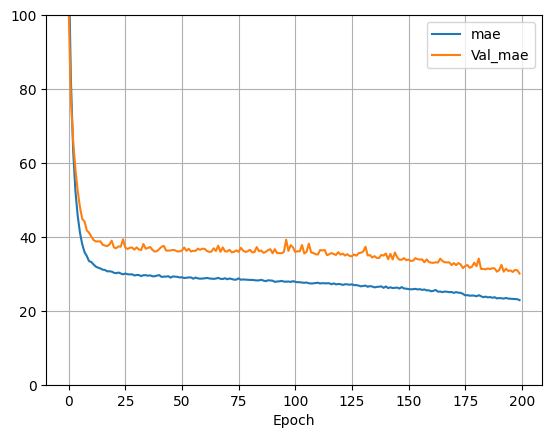

In [34]:
plot_mae(scaled_history)

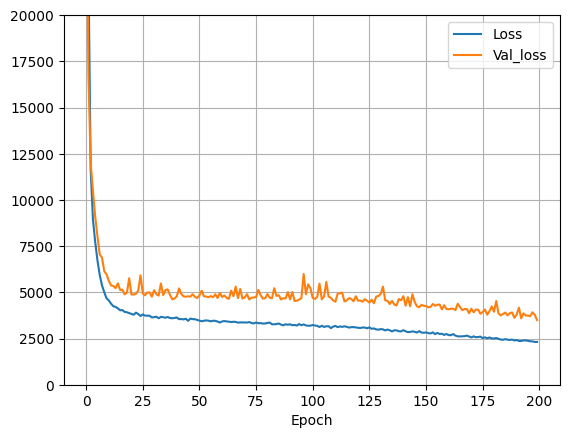

In [35]:
plot_loss(scaled_history)

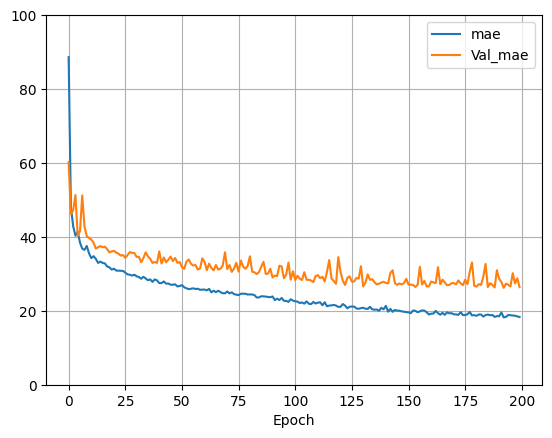

In [36]:
plot_mae(non_scaled_history)

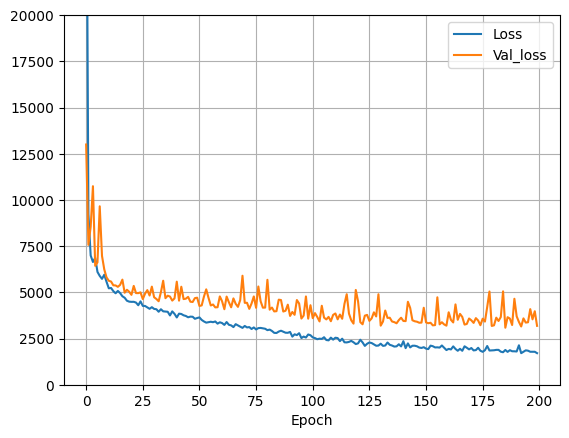

In [37]:
plot_loss(non_scaled_history)

# Zapisanie najepszego modelu do pliku

In [32]:
best_scaled_model.save("../Models/cooling_scaled_model.keras")
best_nonscaled_model.save("../Models/cooling_nonscaled_model.keras")